In [ ]:
# !pip install tensorflow opencv-python matplotlib numpy scikit-learn albumentations imageio

# Loading and Preprecessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os

DATASET_PATH = "/content/drive/MyDrive/lesion_segmentation"
print("Dataset Path:", DATASET_PATH)

# List files to check
print(os.listdir(DATASET_PATH))


Dataset Path: /content/drive/MyDrive/lesion_segmentation
['valid', 'train', 'test']


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import imageio  # For reading .tif images
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Input, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
import albumentations as A

IMAGE_SIZE = (256, 256)

# Define augmentation pipeline
def get_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),  # Randomly flip horizontally
        A.VerticalFlip(p=0.4),  # Randomly flip vertically
        A.Rotate(limit=15, p=0.3),  # Rotate within ±15 degrees
        A.RandomBrightnessContrast(p=0.3),  # Adjust brightness/contrast
        A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),  # Slight warping
        A.GridDistortion(p=0.3),  # Distort grid
        A.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.8, 1.0), p=0.4),
    ])

# Function to apply augmentation
def augment_image_and_mask(image, mask):
    aug = get_augmentation()
    augmented = aug(image=image, mask=mask)  # Apply same augmentation to both
    return augmented['image'], augmented['mask']

In [ ]:
def load_images_and_masks(folder, mask_type, augment):
    images = []
    masks = []

    image_folder = os.path.join(folder, "image")
    mask_folder = os.path.join(folder, "label", mask_type)  # Choose EX, ME, SE, or HE

    # Sort filenames for correct mapping
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    # Check if image and mask counts match
    if len(image_files) != len(mask_files):
        print(f"Warning: {len(image_files)} images found, but {len(mask_files)} masks found.")

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        # Load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img / 255.0   # Normalize

        # Load and preprocess mask (.tif format)
        mask = imageio.imread(mask_path)  # Read .tif file
        mask = cv2.resize(mask, IMAGE_SIZE)  # Resize
        mask = mask / 255.0  # Normalize

        if augment:
            if np.random.rand() > 0.6:
                images.append(img)
                masks.append(mask)
            img, mask = augment_image_and_mask(img, mask)
            images.append(img)
            masks.append(mask)
        else:
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)


In [ ]:
train_images, train_masks = load_images_and_masks(os.path.join(DATASET_PATH, "train"), "EX", True)
val_images, val_masks = load_images_and_masks(os.path.join(DATASET_PATH, "valid"), "EX", False)
test_images, test_masks = load_images_and_masks(os.path.join(DATASET_PATH, "test"), "EX", False)

print("Train Data Shape:", train_images.shape, train_masks.shape)
print("Validation Data Shape:", val_images.shape, val_masks.shape)
print("Test Data Shape:", test_images.shape, test_masks.shape)

<ipython-input-5-877ec2c36383>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)  # Read .tif file
<ipython-input-4-dd09f8fb1ce3>:12: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),  # Slight warping


Train Data Shape: (538, 256, 256, 3) (538, 256, 256, 1)
Validation Data Shape: (149, 256, 256, 3) (149, 256, 256, 1)
Test Data Shape: (225, 256, 256, 3) (225, 256, 256, 1)


In [ ]:
print(f"Pixel value range in image: ({train_images[0].max()}, {train_images[0].min()})")
print(f"Pixel value range in mask: ({train_masks.max()}, {train_masks.min()})")

Pixel value range in image: (1.0, 0.036663613203820056)
Pixel value range in mask: (1.0, 0.0)


In [ ]:
# Converting float masks to binary masks
train_masks = (train_masks > 0.5).astype(np.uint8)
val_masks = (val_masks > 0.5).astype(np.uint8)
test_masks = (test_masks > 0.5).astype(np.uint8)

In [ ]:
print(f"Pixel value range in image: ({train_images[0].max()}, {train_images[0].min()})")
print(f"Pixel value range in mask: ({train_masks.max()}, {train_masks.min()})")

Pixel value range in image: (1.0, 0.036663613203820056)
Pixel value range in mask: (1, 0)


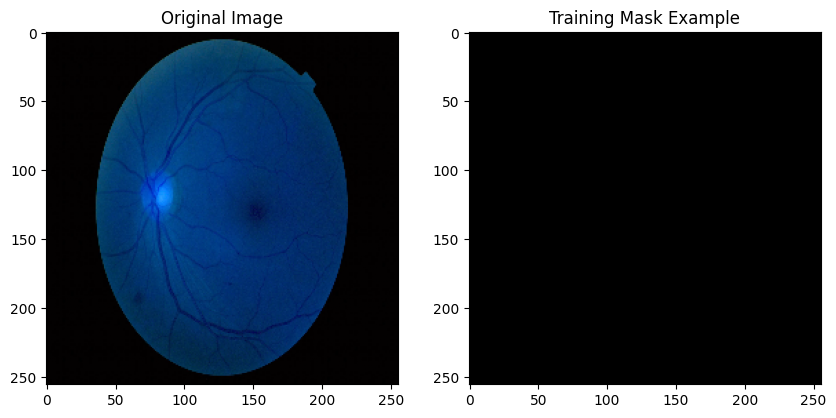

In [ ]:
#Example image - mask pair
i = np.random.randint(0, train_images.shape[0])
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(train_images[i].squeeze(), cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(train_masks[i].squeeze(), cmap='gray')
plt.title("Training Mask Example")
plt.show()

# Defining model

In [ ]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder (Contracting Path)
    c1 = Conv2D(64, 3, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, 3, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, 3, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, 3, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, 3, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(256, 3, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, 3, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(512, 3, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, 3, padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(1024, 3, padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)  # Optional: Prevent overfitting

    # Decoder (Expanding Path)
    u6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, 3, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(512, 3, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, 3, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(256, 3, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, 3, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(128, 3, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, 3, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(64, 3, padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import average_precision_score

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)  # Compute Binary Cross-Entropy
        bce_exp = K.exp(-bce)  # Exponentiate BCE
        focal_loss = alpha * (1 - bce_exp) ** gamma * bce  # Apply Focal Loss formula
        return K.mean(focal_loss)
    return loss

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    y_true = K.cast(y_true, K.floatx())
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def iou_metric(y_true, y_pred):
    smooth = 1e-6
    y_pred = K.round(y_pred)  # Convert to binary
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Cast y_pred to float32
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def average_precision(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return average_precision_score(y_true.numpy(), y_pred.numpy())

In [ ]:
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=[iou_metric, dice_coefficient])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), batch_size=8, epochs=10)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - dice_coefficient: 0.0058 - iou_metric: 0.0029 - loss: 0.0263 - val_dice_coefficient: 0.0526 - val_iou_metric: 0.0526 - val_loss: 0.0284
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 554ms/step - dice_coefficient: 2.7625e-04 - iou_metric: 1.3865e-04 - loss: 0.0018 - val_dice_coefficient: 0.0526 - val_iou_metric: 0.0526 - val_loss: 0.0095
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - dice_coefficient: 1.1880e-04 - iou_metric: 5.9528e-05 - loss: 0.0012 - val_dice_coefficient: 0.0526 - val_iou_metric: 0.0526 - val_loss: 0.0036
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 549ms/step - dice_coefficient: 9.3494e-04 - iou_metric: 4.9276e-04 - loss: 0.0010 - val_dice_coefficient: 0.0526 - val_iou_metric: 0.0526 - val_loss: 0.0012
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 522ms/step - dice_coefficient: 0.0034 - iou_metric: 0.0017 - loss: 0.0011 - val_dice_coefficient: 0.0526 - val_iou_metric: 0.0526 - val_loss: 8.5825e-04
Epoch 6/10
68/68 ━━

In [ ]:
# # Save the model's architecture and weights
# model.save('/content/drive/MyDrive/lesion_segmentation/unet_model.h5')

# print("Model saved to Google Drive.")

Model saved to Google Drive.


In [ ]:
# # To load the model later:
# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/MyDrive/lesion_segmentation/unet_model.h5', custom_objects={'focal_loss': focal_loss, 'iou_metric': iou_metric, 'dice_coefficient': dice_coefficient})

# Model Evaluation

In [ ]:
# Predictions
test_preds = model.predict(test_images)
val_preds = model.predict(val_images)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step


In [ ]:
def find_best_threshold(y_true, y_pred):
    best_threshold = 0.5
    best_iou = 0.0

    for t in np.arange(0.1, 0.6, 0.05):
        binary_pred = (y_pred > t).astype(np.uint8)
        intersection = np.logical_and(y_true, binary_pred).sum()
        union = np.logical_or(y_true, binary_pred).sum()
        iou = intersection / (union + 1e-6)  # Avoiding division by zero

        if iou > best_iou:
            best_iou = iou
            best_threshold = t
    return best_threshold

In [ ]:
optimal_threshold = find_best_threshold(val_masks, val_preds)
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.30000000000000004


In [ ]:
optimal_threshold = find_best_threshold(test_masks, test_preds)
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.20000000000000004


In [ ]:
# Concatenate the masks and predictions along axis 0
combined_masks = np.concatenate([test_masks, val_masks], axis=0)
combined_preds = np.concatenate([test_preds, val_preds], axis=0)

# Find the best threshold using the combined data
optimal_threshold = find_best_threshold(combined_masks, combined_preds)
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.20000000000000004


In [ ]:
test_preds = (test_preds > optimal_threshold).astype(np.uint8)
val_preds = (val_preds > optimal_threshold).astype(np.uint8)

In [ ]:
print("IoU Score on validation data:", iou_metric(val_masks, val_preds))
print("Average Precision on validation data:", average_precision(val_masks, val_preds))

IoU Score on validation data: tf.Tensor(0.032365907, shape=(), dtype=float32)
Average Precision on validation data: 0.007690939147455856


In [ ]:
print("IoU Score on test data:", iou_metric(test_masks, test_preds))
print("Average Precision on test data:", average_precision(test_masks, test_preds))

IoU Score on test data: tf.Tensor(0.11187698, shape=(), dtype=float32)
Average Precision on test data: 0.042892589430635106


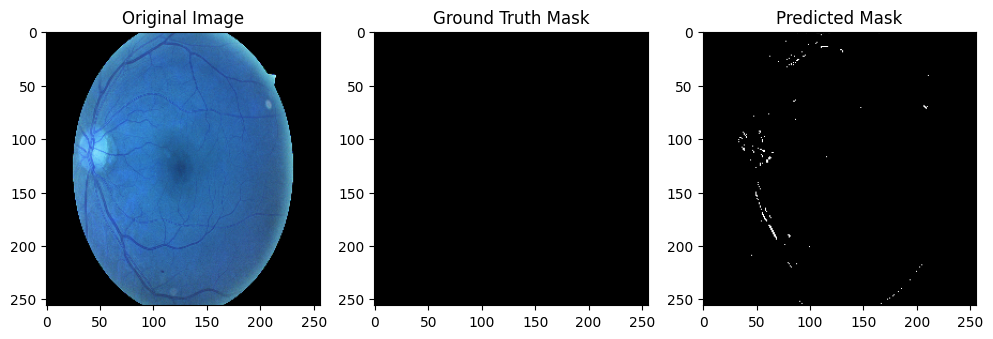

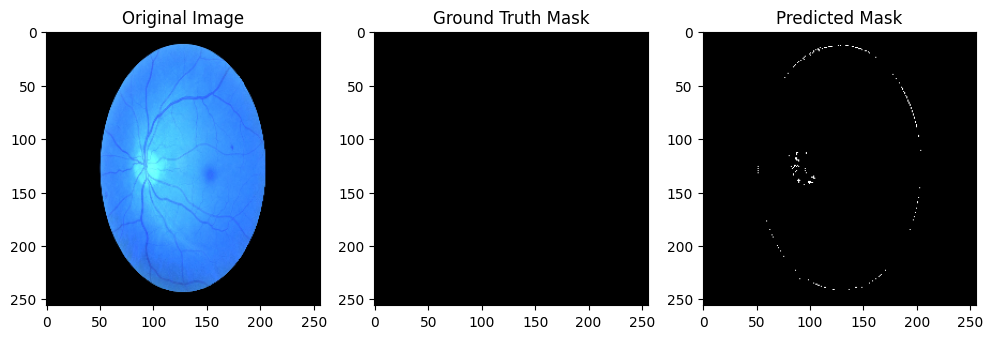

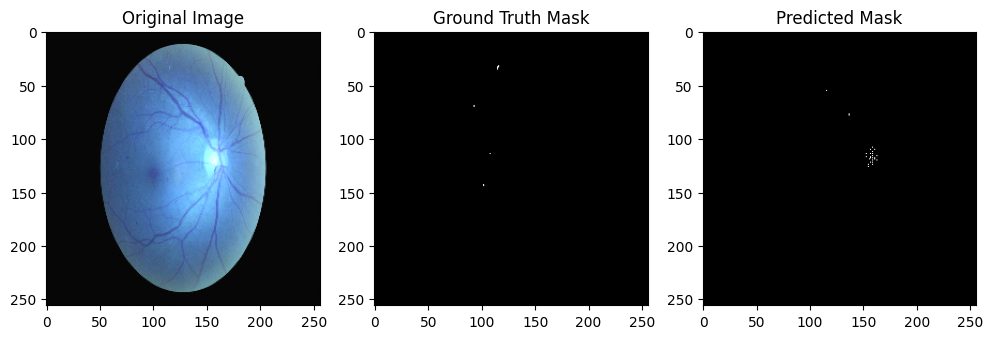

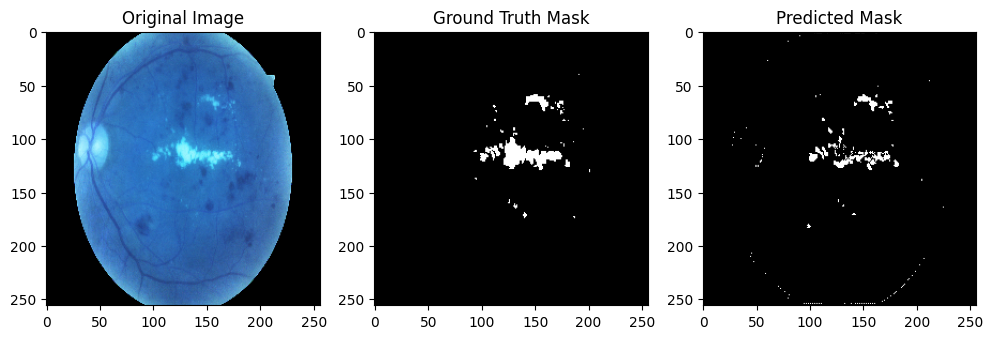

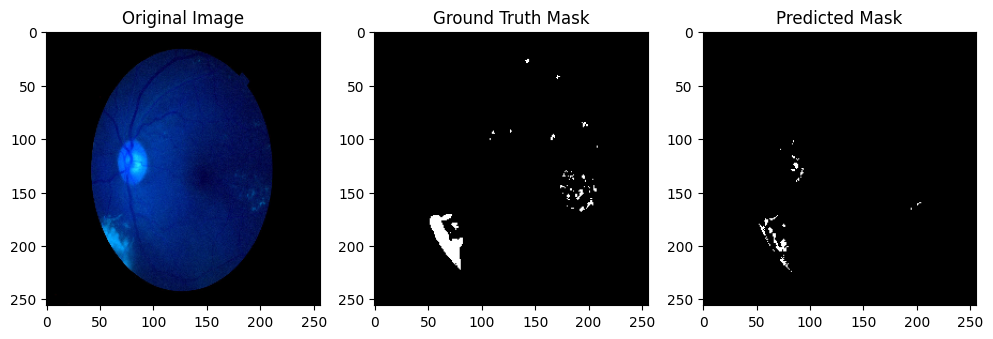

In [ ]:
def visualize_prediction(images, masks, num_samples=5):

    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(images[idx])
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[idx].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(test_preds[idx].squeeze(), cmap="gray")
        plt.title("Predicted Mask")

        plt.show()

visualize_prediction(test_images, test_masks)